In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os, shutil
from tqdm import tqdm
import pickle
import math

from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
# from keras_applications.resnet import ResNet152
# from keras.applications.inception_v3 import InceptionV3
# from keras.applications.inception_v3 import preprocess_input
# from keras_efficientnets.efficientnet import EfficientNetB3
# from keras_efficientnets.efficientnet import preprocess_input

from keras.preprocessing import image

from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten,Input, concatenate, Conv2D, BatchNormalization, MaxPooling2D, Activation
from keras.models import Model, Sequential, load_model
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras import backend, layers, models,utils


import numpy as np
import pandas as pd
from collections import Counter
import tensorflow as tf
from tensorflow.python.client import device_lib
from sklearn.model_selection import train_test_split
print(device_lib.list_local_devices())

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12595047463170636152
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7061687501
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13243204908062269976
physical_device_desc: "device: 0, name: GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


为每个版本设编号

In [2]:
ID = 30

In [3]:
im_width, im_height = 224, 224
lr = 0.000001
batch_size = 32
epochs = 40
valid_size = 0.2

## 预处理

切分训练集和验证集。

In [4]:
with open('clean_data.txt', 'rb') as cd:
    clean_data = pickle.load(cd)

In [5]:
data_dir = './train/'

with open('data_set.txt', 'rb') as ds:
    data_set = pickle.load(ds)
file_df = pd.DataFrame({'file_names': clean_data, 'labels': [x.split('.')[0] for x in clean_data]})
file_train, file_valid, label_train, label_valid = train_test_split(file_df['file_names'], file_df['labels'],
                                                                    test_size = valid_size, random_state = 123)
file_valid = file_valid.tolist()
file_train = file_train.tolist()
print(len(file_train), len(file_valid), len(label_train), len(label_valid))
file_df.head()

19894 4974 19894 4974


,file_names,labels
0,cat.0.jpg,cat
1,cat.1.jpg,cat
2,cat.10.jpg,cat
3,cat.100.jpg,cat
4,cat.1000.jpg,cat


In [6]:
data_set = {'file_train': file_train, 'label_train': label_train, 'file_valid': file_valid, 'label_valid': label_valid}
with open('data_set.txt', 'wb') as ds:
    pickle.dump(data_set, ds)

检查训练集和验证集样本分布。

In [7]:
dataf = {x: pd.DataFrame({'X': data_set['file_{}'.format(x)],
                          'Y'.format(x): data_set['label_{}'.format(x)]}) for x in ['train', 'valid']}
dataf['train'].head()

,X,Y
2551,cat.12312.jpg,cat
9057,cat.6969.jpg,cat
13114,dog.10654.jpg,dog
9469,cat.7340.jpg,cat
14249,dog.11679.jpg,dog


数据增强。

In [8]:
datagen = {x: image.ImageDataGenerator(preprocessing_function=preprocess_input) for x in dataf.keys()}
# datagen = image.ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=valid_size)
datagen['train'].horizontal_flip = True
datagen['train'].shear_range = 0.2
datagen['train'].zoom_range = [0.8, 1.2]
# datagen = image.ImageDataGenerator(preprocessing_function=preprocess_input,
#                                   horizontal_flip=True,
#                                   shear_range=0.2,
#                                   zoom_range=[0.8, 1.2])

In [9]:
generator = {x: datagen[x].flow_from_dataframe(
    dataf[x], x_col = 'X', y_col = 'Y',directory = data_dir.format('train'),
    target_size=(im_width, im_height),
    batch_size=batch_size,
    seed = 123,
    class_mode = 'binary',
    shuffle = True
) for x in datagen.keys()}
# generator = datagen.flow_from_dataframe(
#     file_df, x_col='file_names', y_col='labels', directory=data_dir.format('train'),
#      target_size=(im_width, im_height),
#     batch_size=batch_size,
#     seed = 123,
#     class_mode = 'binary',
#     shuffle=True
# )

Found 19894 validated image filenames belonging to 2 classes.
Found 4974 validated image filenames belonging to 2 classes.


## 构建模型

In [10]:
# model_base = ResNet152(weights = 'imagenet', include_top = False, input_shape = (im_width, im_height, 3),
#                            backend = backend, layers = layers, models = models, utils = utils)
model_base = ResNet50(weights = 'imagenet', include_top = False, input_shape = (im_width, im_height, 3))
model = Sequential()
model.add(model_base)
model.add(GlobalAveragePooling2D(name = 'm{}_gap_1'.format(ID)))
model.add(Dropout(0.75, name = 'm{}_dropout_1'.format(ID)))
model.add(Dense(1024, activation = 'relu', name = 'm{}_dense_1'.format(ID)))
model.add(Dropout(0.5, name = 'm{}_dropout_2'.format(ID)))
model.add(Dense(500, activation = 'relu', name = 'm{}_dense_2'.format(ID)))
model.add(Dropout(0.5, name = 'm{}_dropout_3'.format(ID)))
model.add(Dense(1, activation='sigmoid', name = 'm{}_dense_3'.format(ID)))

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\lucifer\Anaconda3\envs\tf\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [ ]:
# # AlexNet
# model = Sequential()
# #第一段
# model.add(Conv2D(filters=96, kernel_size=(11,11),
#                  strides=(4,4), padding='valid',
#                  input_shape=(im_width,im_height,3),
#                  activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(3,3), 
#                        strides=(2,2), 
#                        padding='valid'))
# #第二段
# model.add(Conv2D(filters=256, kernel_size=(5,5), 
#                  strides=(1,1), padding='same', 
#                  activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(3,3), 
#                        strides=(2,2), 
#                        padding='valid'))
# #第三段
# model.add(Conv2D(filters=384, kernel_size=(3,3), 
#                  strides=(1,1), padding='same', 
#                  activation='relu'))
# model.add(Conv2D(filters=384, kernel_size=(3,3), 
#                  strides=(1,1), padding='same', 
#                  activation='relu'))
# model.add(Conv2D(filters=256, kernel_size=(3,3), 
#                  strides=(1,1), padding='same', 
#                  activation='relu'))
# model.add(MaxPooling2D(pool_size=(3,3), 
#                        strides=(2,2), padding='valid'))
# #第四段
# model.add(Flatten())
# model.add(Dense(4096, activation='relu'))
# model.add(Dropout(0.5))
 
# model.add(Dense(4096, activation='relu'))
# model.add(Dropout(0.5))
 
# model.add(Dense(1000, activation='relu'))
# model.add(Dropout(0.5))

# # Output Layer
# model.add(Dense(512, activation = 'relu', name = 'm{}_dense_1'.format(ID)))
# model.add(Dropout(0.75, name = 'm{}_dropout_1'.format(ID)))
# model.add(Dense(256, activation = 'relu', name = 'm{}_dense_2'.format(ID)))
# model.add(Dropout(0.75, name = 'm{}_dropout_2'.format(ID)))
# model.add(Dense(1))
# model.add(Activation('sigmoid'))

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
m30_gap_1 (GlobalAveragePool (None, 2048)              0         
_________________________________________________________________
m30_dropout_1 (Dropout)      (None, 2048)              0         
_________________________________________________________________
m30_dense_1 (Dense)          (None, 1024)              2098176   
_________________________________________________________________
m30_dropout_2 (Dropout)      (None, 1024)              0         
_________________________________________________________________
m30_dense_2 (Dense)          (None, 500)               512500    
_________________________________________________________________
m30_dropout_3 (Dropout)      (None, 500)               0         
__________

In [12]:
# print('Number of trainable weights bef？or freezing the model_base:', len(model.trainable_weights))
# model_base.trainable = False
print('Number of trainable weights after freezing the model_base:', len(model.trainable_weights))

Number of trainable weights after freezing the model_base: 218


## 训练模型

In [13]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
# early_stopping = EarlyStopping(monitor='loss', patience=5)
model.compile(loss = "binary_crossentropy", optimizer = optimizers.Adam(lr=lr), metrics=["accuracy"])
# model.compile(loss = "binary_crossentropy", optimizer = optimizers.SGD(lr=lr, momentum = 0.9), metrics=["accuracy"])
history = model.fit_generator(generator['train'],
                              steps_per_epoch=len(generator['train']),
                              epochs=epochs,
                              validation_data=generator['valid'],
                              validation_steps=len(generator['valid']),
                              callbacks=[early_stopping],
                              verbose = 2)
# history = model.fit_generator(generator,
#                               steps_per_epoch=math.ceil(generator.samples / batch_size),
#                               epochs=epochs,
#                               callbacks=[early_stopping],
#                               verbose = 2)

model.save('models/model_{}.h5'.format(ID))

Instructions for updating:
Use tf.cast instead.
Epoch 1/40
 - 188s - loss: 1.0727 - acc: 0.5267 - val_loss: 0.5584 - val_acc: 0.7531
Epoch 2/40
 - 179s - loss: 0.9060 - acc: 0.5891 - val_loss: 0.4050 - val_acc: 0.8926
Epoch 3/40
 - 173s - loss: 0.7554 - acc: 0.6549 - val_loss: 0.2884 - val_acc: 0.9419
Epoch 4/40
 - 168s - loss: 0.6061 - acc: 0.7261 - val_loss: 0.1987 - val_acc: 0.9630
Epoch 5/40
 - 169s - loss: 0.4685 - acc: 0.7897 - val_loss: 0.1354 - val_acc: 0.9727
Epoch 6/40
 - 174s - loss: 0.3603 - acc: 0.8415 - val_loss: 0.0998 - val_acc: 0.9781
Epoch 7/40
 - 182s - loss: 0.2877 - acc: 0.8778 - val_loss: 0.0769 - val_acc: 0.9819
Epoch 8/40
 - 176s - loss: 0.2245 - acc: 0.9062 - val_loss: 0.0601 - val_acc: 0.9835
Epoch 9/40
 - 170s - loss: 0.1883 - acc: 0.9224 - val_loss: 0.0513 - val_acc: 0.9839
Epoch 10/40
 - 226s - loss: 0.1531 - acc: 0.9383 - val_loss: 0.0435 - val_acc: 0.9857
Epoch 11/40
 - 263s - loss: 0.1257 - acc: 0.9508 - val_loss: 0.0384 - val_acc: 0.9867
Epoch 12/40
 - 

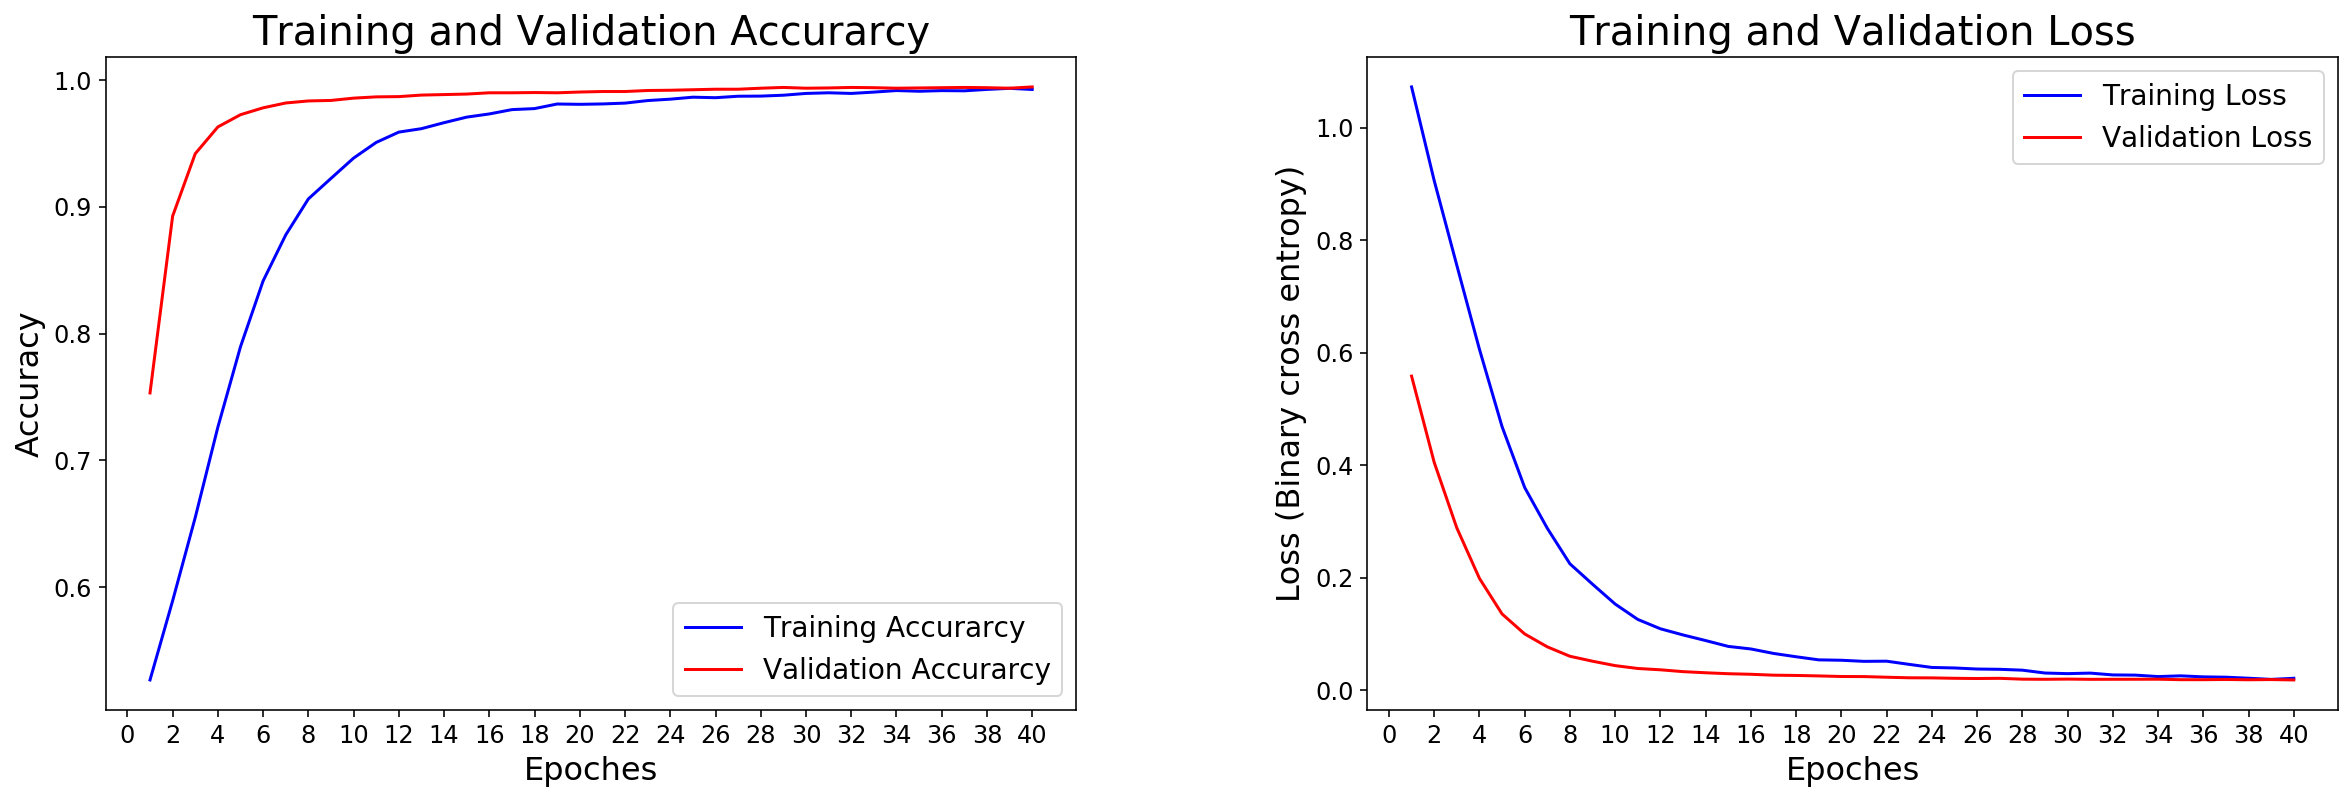

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

x_axis = range(1, len(acc)+1)

plt.figure(figsize = [20, 6])
plt.subplots_adjust(wspace=0.3)
plt.subplot(1,2,1)
plt.plot(x_axis, acc, 'blue', label='Training Accurarcy')
plt.plot(x_axis, val_acc, 'red', label='Validation Accurarcy')
plt.title('Training and Validation Accurarcy', fontsize = 20)
plt.xlabel('Epoches', fontsize = 16)
plt.ylabel('Accuracy', fontsize = 16)
plt.legend(fontsize = 14)
plt.xticks(ticks=range(0, len(acc)+1, 2),fontsize = 12)
plt.yticks(fontsize = 12)

plt.subplot(1,2,2)
plt.plot(x_axis, loss, 'blue', label='Training Loss')
plt.plot(x_axis, val_loss, 'red', label='Validation Loss')
plt.title('Training and Validation Loss', fontsize = 20)
plt.xlabel('Epoches', fontsize = 16)
plt.ylabel('Loss (Binary cross entropy)', fontsize = 16)
plt.legend(fontsize = 14)
plt.xticks(ticks=range(0, len(acc)+1, 2), fontsize = 12)
plt.yticks(fontsize = 12)

# plt.suptitle('Pre-trained model: {}\nLearning rate: {}'.format(model_name, lr),
#             x = 0.1, y = 1, ha = 'left', fontsize = 14)
plt.savefig('results/Loss and Accuracy {}.jpg'.format(ID), bbox_inches = 'tight')

## 预测

In [15]:
test_imgs = os.listdir('test/')
ids = []
label = []
for i in tqdm(test_imgs):
    img = image.load_img('test/' + i, target_size=(im_width, im_height))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    label.append(model.predict(x)[0][0])
    ids.append(int(i.split('.')[0]))
sub = pd.DataFrame({'id': ids, 'label': label}).sort_values('id',axis = 0, ascending = True)
sub.to_csv('results/submission {}.csv'.format(ID), index = False)

100%|████████████████████████████████████████████████████████████████████████████| 12500/12500 [13:55<00:00, 14.96it/s]


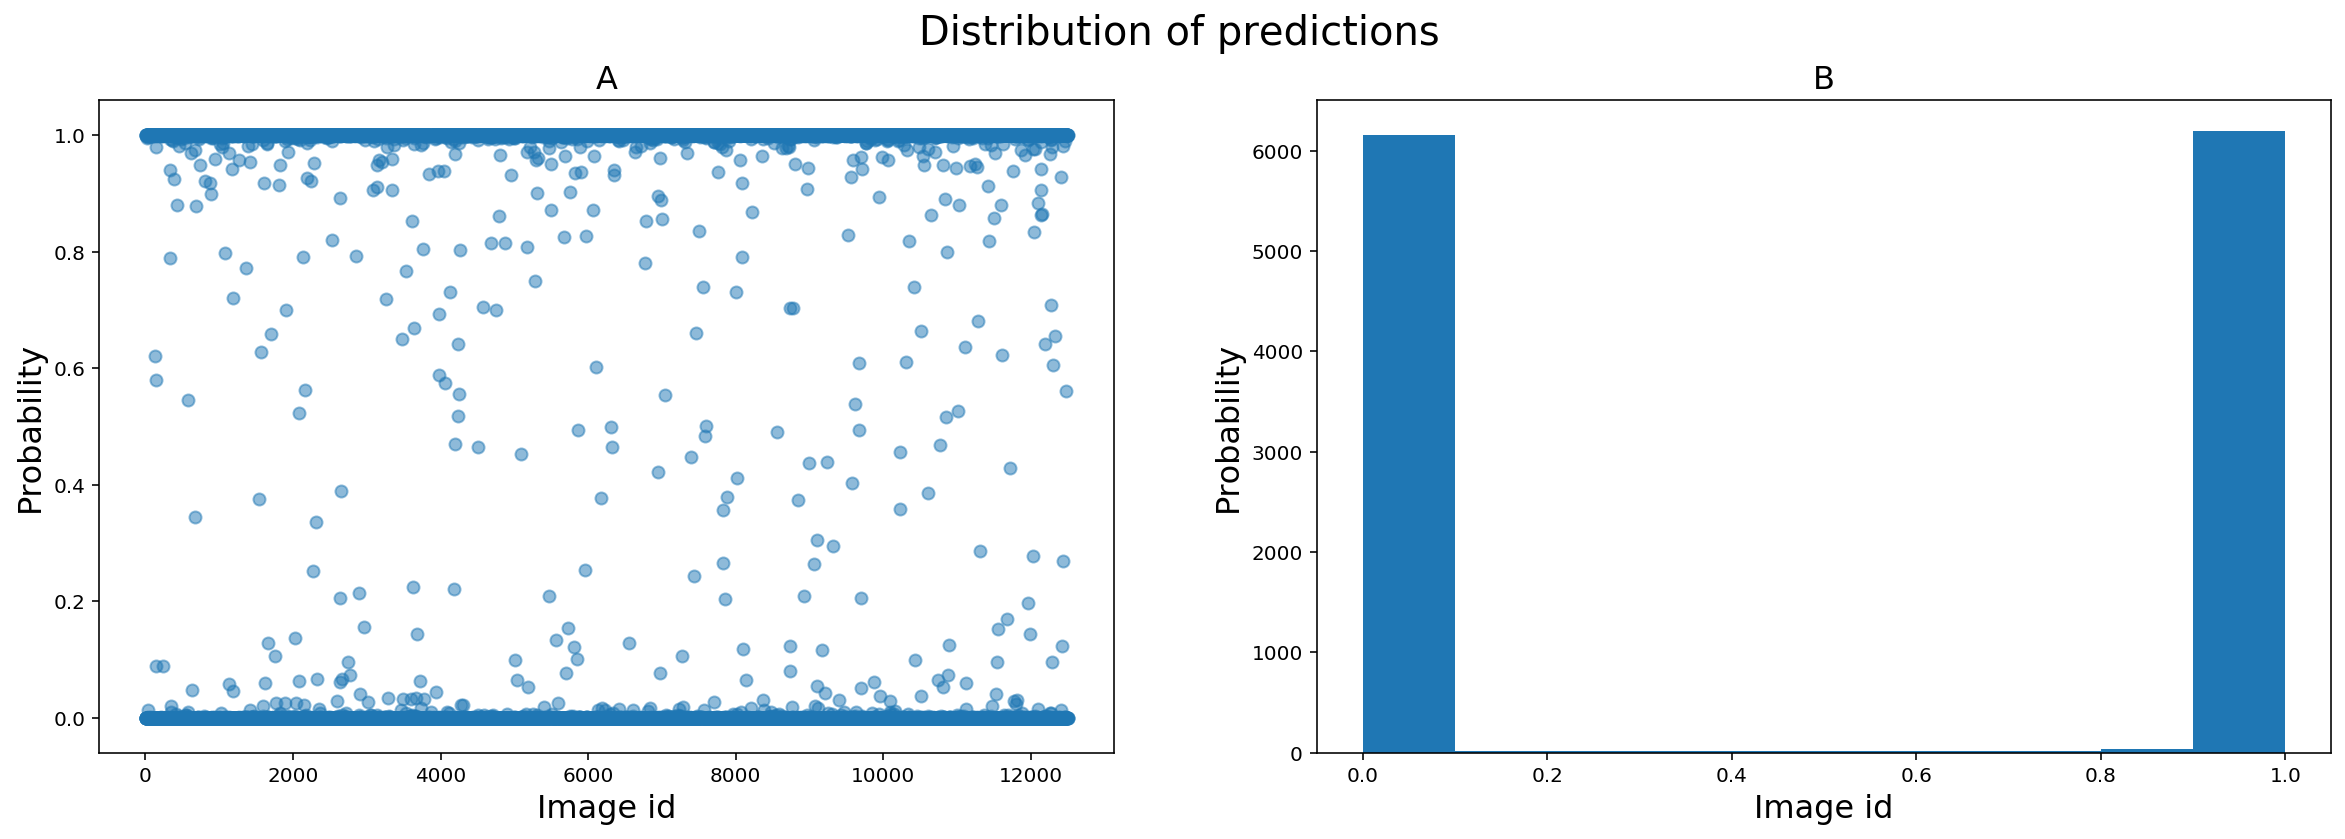

In [16]:
plt.figure(figsize=[20, 6])

plt.subplot(1, 2, 1)
plt.scatter(sub['id'], sub['label'], alpha=0.5);
plt.title('A', fontsize = 16)
plt.xlabel('Image id', fontsize = 16)
plt.ylabel('Probability', fontsize = 16)

plt.subplot(1, 2, 2)
plt.hist(sub['label'], bins=10)
plt.title('B', fontsize = 16)
plt.xlabel('Image id', fontsize = 16)
plt.ylabel('Probability', fontsize = 16)

plt.suptitle('Distribution of predictions', fontsize = 20)

plt.savefig('results/distribution_of_predictions_0.jpg', bbox_inches = 'tight');

In [17]:
with open('models/history {}.txt'.format(ID), 'wb') as his:
    pickle.dump(history, his)

1.7150122e-09


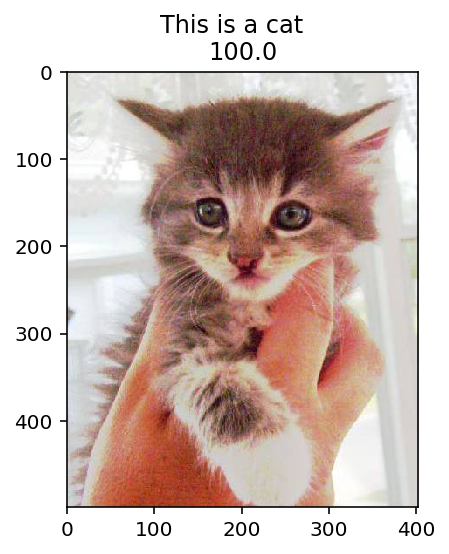

In [18]:
test_imgs = os.listdir(data_dir.format('test'))
img_path = data_dir.format('test') + test_imgs[3]
# img_path = './test04.jpg'
img = image.load_img(img_path, target_size=(im_width, im_height))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)[0][0]
print(preds)
img_show = mpimg.imread(img_path)
plt.imshow(img_show)
plt.suptitle('This is a {}'.format('dog' if preds > 0.5 else 'cat'))
plt.title('probability: {}%'.format(round(preds*100, 2)) if preds > 0.5 else round((1-preds)*100, 2));

In [19]:
os.system('jupyter nbconvert Capstone.ipynb --to html --output results/Capstone_{}'.format(ID))

0